<a href="https://colab.research.google.com/github/LoveyThePigeon/GAM-for-Air-Pollution-Prediction/blob/main/NewGAMCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [165]:
####################################################
# SETUP & LOADING
####################################################
# !pip install openpyxl
!pip -q install pygam

from IPython.display import display
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from pygam import LinearGAM, GAM, s
from pygam.terms import TermList
from pygam.distributions import GammaDist
from pygam.links import LogLink
import scipy.stats as stats

# loads data
from google.colab import files
uploaded = files.upload()
df = pd.read_excel("PM10 air pollution.xlsx")
#df = pd.read_csv("/content/PM10 air pollution.csv")


Saving PM10 air pollution.xlsx to PM10 air pollution (7).xlsx


In [166]:
# displays sample data and other information

print("\n########## FIRST 5 ROWS ##########\n")
display(df.head())


########## FIRST 5 ROWS ##########



,AMP_TMP,CO,NO,NO2,Nox,O3,RH,SO2,WD,WS,PM10
0,12.670417,0.312083,1.323333,8.376667,9.699583,33.691667,57.446250,4.658333,272.775417,3.018333,57.833333
1,14.385000,0.260000,2.504583,8.888750,11.393333,28.487500,55.859583,1.933333,276.061667,2.148333,36.125000
2,16.442083,0.405000,3.340000,11.644583,14.985000,24.254167,66.623750,2.362500,237.068750,1.344167,33.083333
3,17.459583,0.308333,4.354167,12.362500,16.715833,19.541667,78.750000,1.379167,198.881250,1.231250,28.500000
4,17.684583,0.347917,5.223750,15.370417,20.594167,20.241667,90.202917,2.570833,210.563333,1.612083,16.666667


In [167]:
# Prints code for latex for sample data table

latex_code_sample_data = df.head().to_latex(index=True, float_format="{:.2f}".format)
print(latex_code_sample_data)

\begin{tabular}{lrrrrrrrrrrr}
\toprule
 & AMP_TMP & CO & NO & NO2 & Nox & O3 & RH & SO2 & WD & WS & PM10 \\
\midrule
0 & 12.67 & 0.31 & 1.32 & 8.38 & 9.70 & 33.69 & 57.45 & 4.66 & 272.78 & 3.02 & 57.83 \\
1 & 14.38 & 0.26 & 2.50 & 8.89 & 11.39 & 28.49 & 55.86 & 1.93 & 276.06 & 2.15 & 36.12 \\
2 & 16.44 & 0.41 & 3.34 & 11.64 & 14.98 & 24.25 & 66.62 & 2.36 & 237.07 & 1.34 & 33.08 \\
3 & 17.46 & 0.31 & 4.35 & 12.36 & 16.72 & 19.54 & 78.75 & 1.38 & 198.88 & 1.23 & 28.50 \\
4 & 17.68 & 0.35 & 5.22 & 15.37 & 20.59 & 20.24 & 90.20 & 2.57 & 210.56 & 1.61 & 16.67 \\
\bottomrule
\end{tabular}



In [168]:
print("\n########## DATA TYPES AND MISSING VALUES ##########\n")
display(df.info())


########## DATA TYPES AND MISSING VALUES ##########

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AMP_TMP  1095 non-null   float64
 1   CO       1095 non-null   float64
 2   NO       1095 non-null   float64
 3   NO2      1095 non-null   float64
 4   Nox      1095 non-null   float64
 5   O3       1095 non-null   float64
 6   RH       1095 non-null   float64
 7   SO2      1095 non-null   float64
 8   WD       1095 non-null   float64
 9   WS       1095 non-null   float64
 10  PM10     1095 non-null   float64
dtypes: float64(11)
memory usage: 94.2 KB


None

In [169]:
print("\n########## SIZE OF THE DATASET ##########\n")
display(df.shape)


########## SIZE OF THE DATASET ##########



(1095, 11)

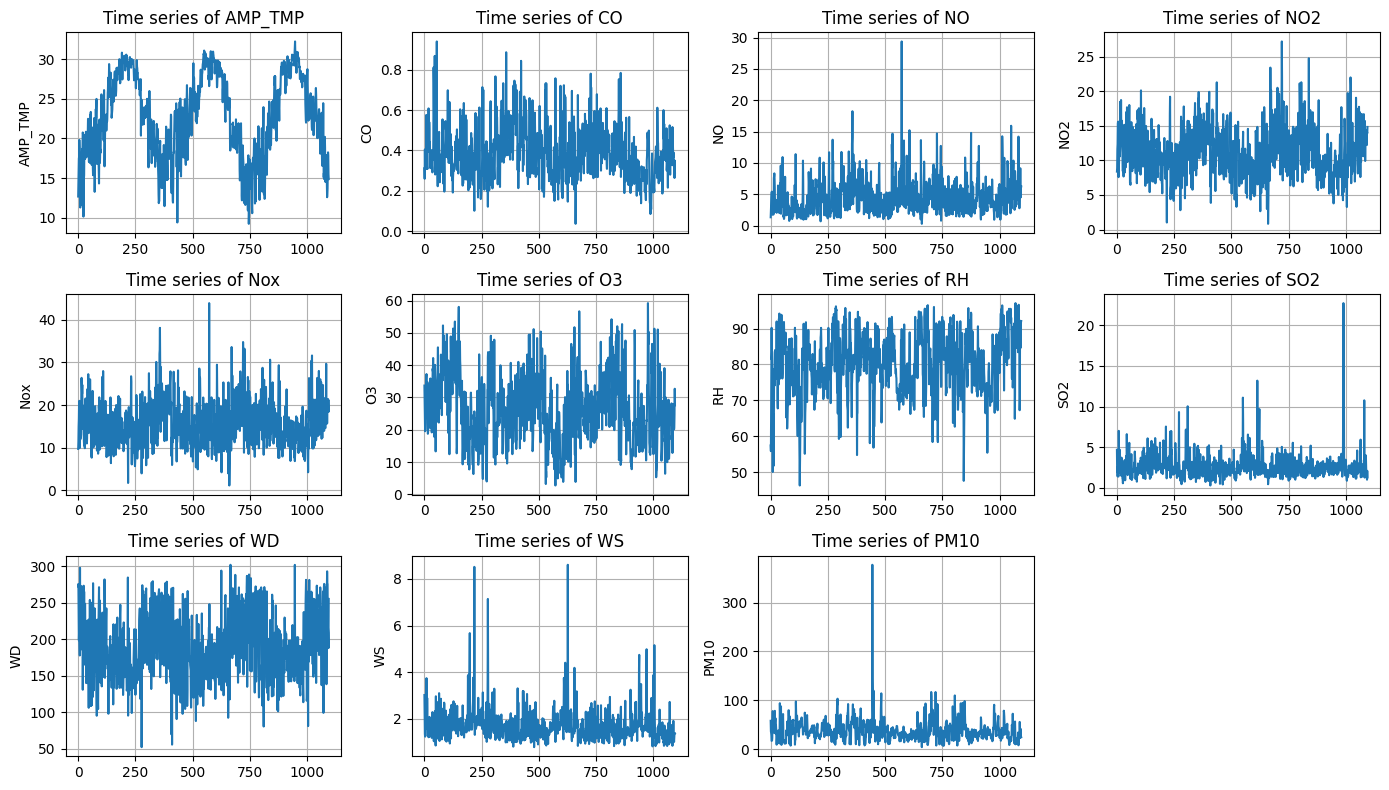

In [170]:
# Time series plots

x_axis = range(len(df))
num_var = len(df.columns)

fig, axs = plt.subplots(3, 4, figsize = (14,8))

axs = axs.flatten()

for i, col in enumerate(df.columns):
    axs[i].plot(x_axis, df[col])
    axs[i].set_title(f"Time series of {col}")
    axs[i].set_ylabel(col)
   # axs[i].set_xlabel()
    axs[i].grid(True)

if num_var < len(axs):
  fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()
print("")




In [171]:
# Saving plot

fig.savefig("Time_series_plots.pdf", bbox_inches='tight')
# files.download("Time_series_plots.pdf")

In [172]:
print("\n########## BASIC STATISTICS ##########\n")
display(df.describe())
print("")



########## BASIC STATISTICS ##########



,AMP_TMP,CO,NO,NO2,Nox,O3,RH,SO2,WD,WS,PM10
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,22.828843,0.387619,4.538489,11.245147,15.786657,26.297643,80.052340,2.623005,190.417638,1.701850,37.979730
std,5.265242,0.125933,2.678347,3.526487,5.244985,10.448085,8.446672,1.583048,44.479622,0.675985,21.226501
min,9.225000,0.037500,0.278750,0.824167,1.103333,2.762500,46.291667,0.262500,52.464167,0.779583,3.833333
25%,18.769167,0.299792,2.663750,8.711458,12.018958,18.920833,74.203542,1.800000,159.243750,1.308333,25.312500
50%,23.010417,0.368333,3.925833,10.897500,15.344167,25.545833,80.305417,2.312500,185.715833,1.563750,34.833333
75%,27.681875,0.466667,5.904167,13.685000,19.098333,33.291667,86.273125,3.041667,220.425208,1.904167,46.479167
max,32.250000,0.938750,29.379583,27.203333,43.938333,59.208333,97.083333,22.750000,302.298333,8.609583,377.500000


In [173]:
# Prints code for latex for basic statistics table

desc_df = df.describe()
latex_code_basic_stat = desc_df.to_latex(index=True, float_format="{:.2f}".format)
print(latex_code_basic_stat)

\begin{tabular}{lrrrrrrrrrrr}
\toprule
 & AMP_TMP & CO & NO & NO2 & Nox & O3 & RH & SO2 & WD & WS & PM10 \\
\midrule
count & 1095.00 & 1095.00 & 1095.00 & 1095.00 & 1095.00 & 1095.00 & 1095.00 & 1095.00 & 1095.00 & 1095.00 & 1095.00 \\
mean & 22.83 & 0.39 & 4.54 & 11.25 & 15.79 & 26.30 & 80.05 & 2.62 & 190.42 & 1.70 & 37.98 \\
std & 5.27 & 0.13 & 2.68 & 3.53 & 5.24 & 10.45 & 8.45 & 1.58 & 44.48 & 0.68 & 21.23 \\
min & 9.22 & 0.04 & 0.28 & 0.82 & 1.10 & 2.76 & 46.29 & 0.26 & 52.46 & 0.78 & 3.83 \\
25% & 18.77 & 0.30 & 2.66 & 8.71 & 12.02 & 18.92 & 74.20 & 1.80 & 159.24 & 1.31 & 25.31 \\
50% & 23.01 & 0.37 & 3.93 & 10.90 & 15.34 & 25.55 & 80.31 & 2.31 & 185.72 & 1.56 & 34.83 \\
75% & 27.68 & 0.47 & 5.90 & 13.69 & 19.10 & 33.29 & 86.27 & 3.04 & 220.43 & 1.90 & 46.48 \\
max & 32.25 & 0.94 & 29.38 & 27.20 & 43.94 & 59.21 & 97.08 & 22.75 & 302.30 & 8.61 & 377.50 \\
\bottomrule
\end{tabular}



In [174]:
print("\n########## OTHER STATISTICS ##########\n")

other_stats = pd.DataFrame({
    'Min' : df.min(),
    'Max' : df.max(),
    'Mean': df.mean(),
    'Median' : df.median(),
    'Std' : df.std(),
    'Variance' : df.var(),
    'Skewness' : df.skew()
})

display(other_stats)
print("")


########## OTHER STATISTICS ##########



,Min,Max,Mean,Median,Std,Variance,Skewness
AMP_TMP,9.225000,32.250000,22.828843,23.010417,5.265242,27.722770,-0.277533
CO,0.037500,0.938750,0.387619,0.368333,0.125933,0.015859,0.711740
NO,0.278750,29.379583,4.538489,3.925833,2.678347,7.173542,1.914839
NO2,0.824167,27.203333,11.245147,10.897500,3.526487,12.436110,0.380052
Nox,1.103333,43.938333,15.786657,15.344167,5.244985,27.509870,0.655129
O3,2.762500,59.208333,26.297643,25.545833,10.448085,109.162478,0.302287
RH,46.291667,97.083333,80.052340,80.305417,8.446672,71.346274,-0.452346
SO2,0.262500,22.750000,2.623005,2.312500,1.583048,2.506042,5.279305
WD,52.464167,302.298333,190.417638,185.715833,44.479622,1978.436771,0.187526
WS,0.779583,8.609583,1.701850,1.563750,0.675985,0.456955,3.651058


In [175]:
# Prints code for latex for other statistics table
latex_code_os = other_stats.to_latex(index=True, float_format="{:.2f}".format)
print(latex_code_os)

\begin{tabular}{lrrrrrrr}
\toprule
 & Min & Max & Mean & Median & Std & Variance & Skewness \\
\midrule
AMP_TMP & 9.22 & 32.25 & 22.83 & 23.01 & 5.27 & 27.72 & -0.28 \\
CO & 0.04 & 0.94 & 0.39 & 0.37 & 0.13 & 0.02 & 0.71 \\
NO & 0.28 & 29.38 & 4.54 & 3.93 & 2.68 & 7.17 & 1.91 \\
NO2 & 0.82 & 27.20 & 11.25 & 10.90 & 3.53 & 12.44 & 0.38 \\
Nox & 1.10 & 43.94 & 15.79 & 15.34 & 5.24 & 27.51 & 0.66 \\
O3 & 2.76 & 59.21 & 26.30 & 25.55 & 10.45 & 109.16 & 0.30 \\
RH & 46.29 & 97.08 & 80.05 & 80.31 & 8.45 & 71.35 & -0.45 \\
SO2 & 0.26 & 22.75 & 2.62 & 2.31 & 1.58 & 2.51 & 5.28 \\
WD & 52.46 & 302.30 & 190.42 & 185.72 & 44.48 & 1978.44 & 0.19 \\
WS & 0.78 & 8.61 & 1.70 & 1.56 & 0.68 & 0.46 & 3.65 \\
PM10 & 3.83 & 377.50 & 37.98 & 34.83 & 21.23 & 450.56 & 4.52 \\
\bottomrule
\end{tabular}



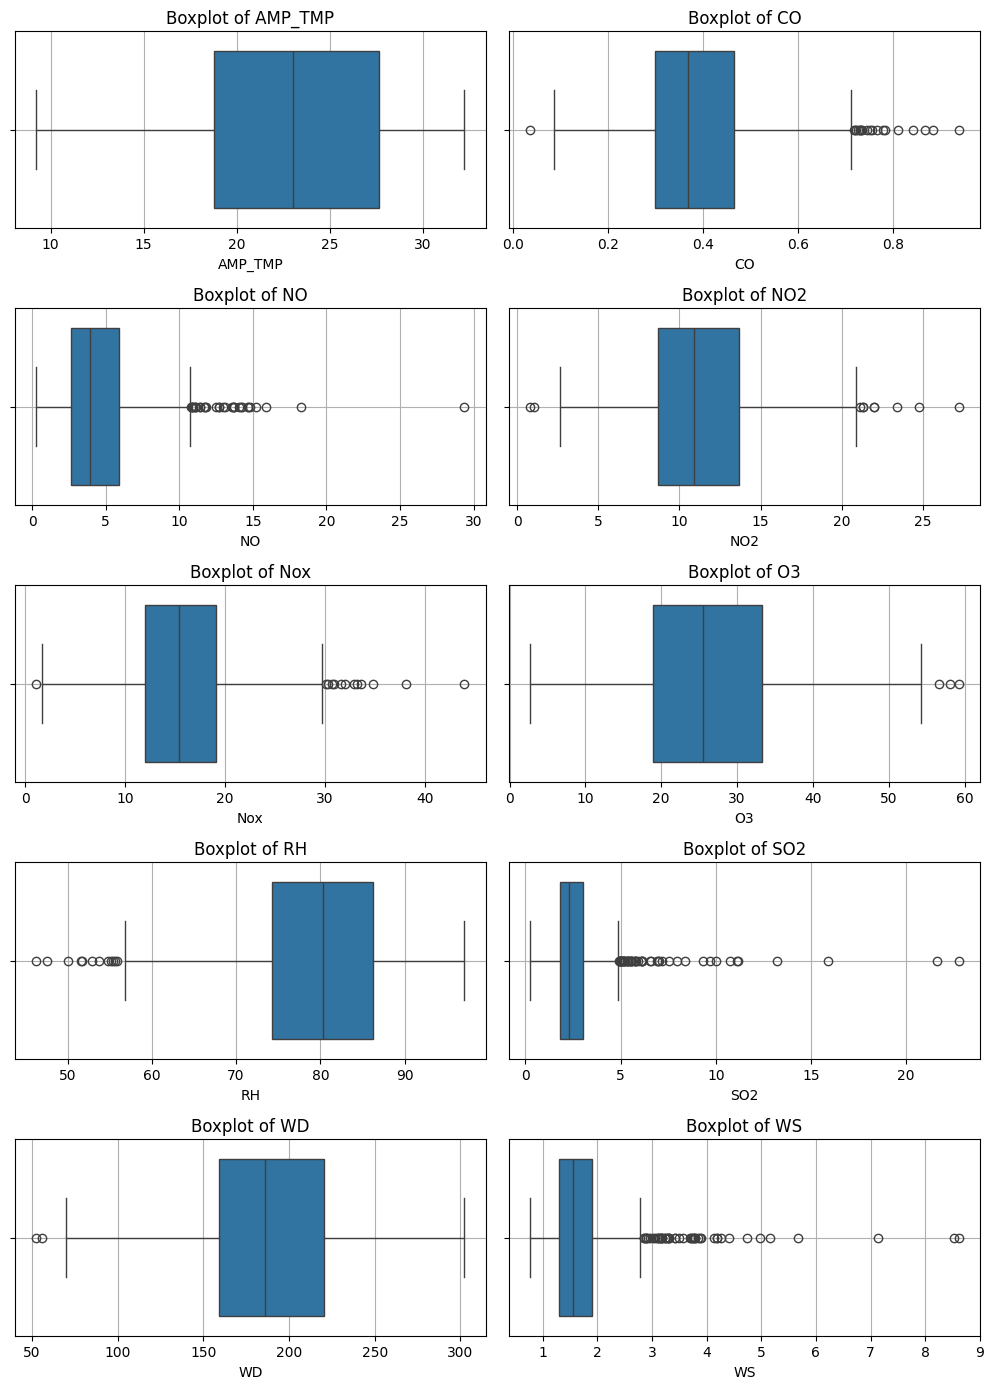



########## SPLITTING ##########

Dimensions of X: 2 2
Dimensions of y: 1 1
Sizes X rows: 876 219
Sizes X columns: 11 11
Sizes y: 876 219


In [176]:
####################################################
# OUTLIERS (visual only)
####################################################
fig, axs = plt.subplots(5, 2 , figsize=(10, 14))
axs = axs.flatten()

# >>> CHANGED: iterate over all feature columns except target by name
feature_cols = [c for c in df.columns if c != 'PM10']   # >>> NEW
for i, col in enumerate(feature_cols):
    sns.boxplot(x=df[col], ax=axs[i])
    axs[i].set_title(f"Boxplot of {col}")
    axs[i].grid(True)

plt.tight_layout()
plt.show()
print("")


####################################################
# >>> NEW: FEATURE ENGINEERING before splitting
# - Cyclic wind direction (WD_sin, WD_cos)
# - Reduce collinearity: drop Nox (keep NO & NO2)
####################################################
if 'WD' in df.columns:                                       # >>> NEW
    df['WD_sin'] = np.sin(np.deg2rad(df['WD']))              # >>> NEW
    df['WD_cos'] = np.cos(np.deg2rad(df['WD']))              # >>> NEW
    #df = df.drop(columns=['WD'])                             # >>> NEW (drop raw WD to avoid redundancy)


if {'NO', 'NO2', 'Nox'}.issubset(df.columns):                # >>> NEW
    df = df.drop(columns=['Nox'])                            # >>> NEW (keep NO & NO2)

# >>> CHANGED: build X,y from updated df (no fixed column counts)
X = df.drop(columns=['PM10']).to_numpy()                     # >>> CHANGED
y = df['PM10'].to_numpy()                                    # >>> CHANGED


####################################################
# SPLITTING DATA 80% - TRAIN, 20% - TEST
####################################################
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\n########## SPLITTING ##########\n")
print("Dimensions of X:", X_train.ndim, X_test.ndim)
print("Dimensions of y:", y_train.ndim, y_test.ndim)
print("Sizes X rows:", X_train.shape[0], X_test.shape[0])
print("Sizes X columns:", X_train.shape[1], X_test.shape[1])
print("Sizes y:", y_train.shape[0], y_test.shape[0])



########## DISTRIBUTION ##########



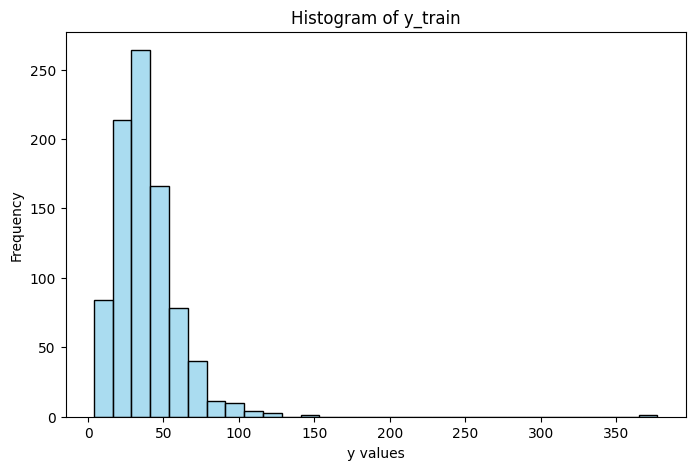

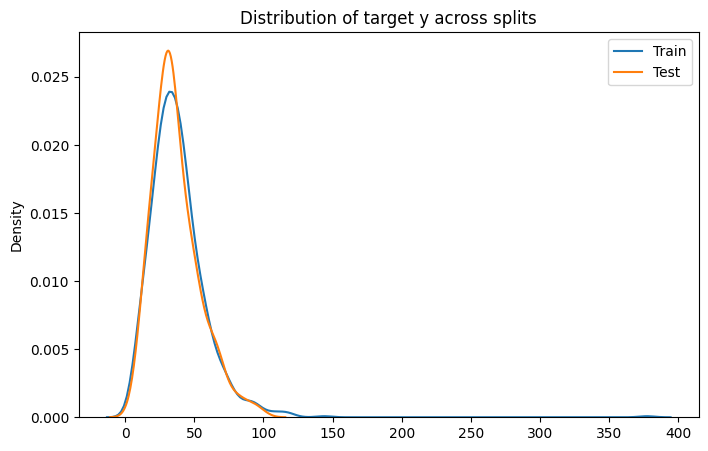

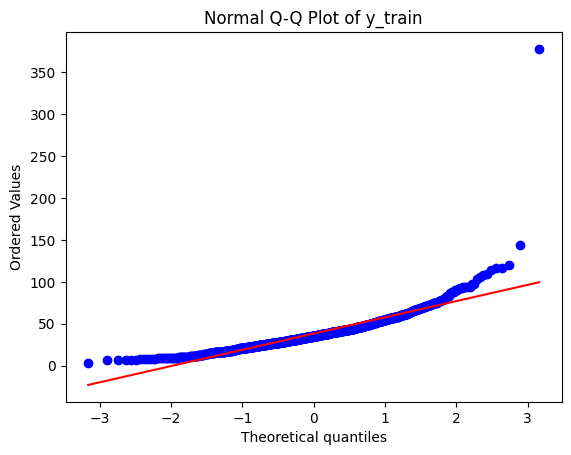

Skewness of y_train: 4.86
All positive


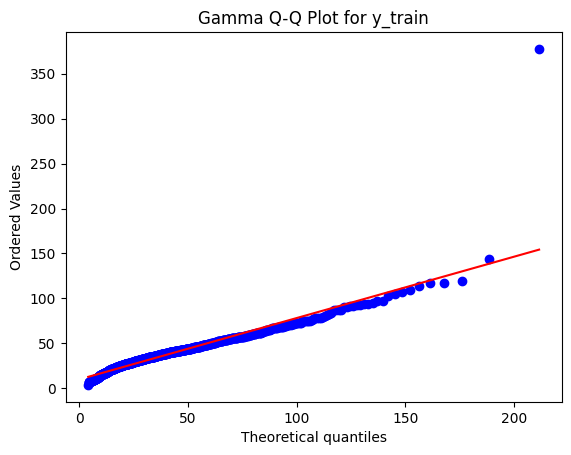

In [177]:
####################################################
# >>> NEW: GENTLE OUTLIER CLIPPING (1st–99th pct) before scaling
####################################################
X_train_df = pd.DataFrame(X_train)                           # >>> NEW
X_test_df  = pd.DataFrame(X_test)                            # >>> NEW
q1 = X_train_df.quantile(0.01)                               # >>> NEW
q99 = X_train_df.quantile(0.99)                              # >>> NEW
X_train_df = X_train_df.clip(q1, q99, axis=1)                # >>> NEW
X_test_df  = X_test_df.clip(q1, q99, axis=1)                 # >>> NEW
X_train = X_train_df.to_numpy()                              # >>> NEW
X_test  = X_test_df.to_numpy()                               # >>> NEW


####################################################
# PREPROCESSING (scaling)
####################################################
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


####################################################
# >>> NEW: OPTIONAL LOG TARGET (recommended: skewed PM10)
####################################################
USE_LOG_TARGET = True                                        # >>> NEW (set False to disable)

if USE_LOG_TARGET:                                           # >>> NEW
    y_train_mod = np.log1p(y_train)                          # >>> NEW
    y_test_mod  = np.log1p(y_test)                           # >>> NEW
else:                                                        # >>> NEW
    y_train_mod = y_train                                    # >>> NEW
    y_test_mod  = y_test                                     # >>> NEW


####################################################
# CHECKING DISTRIBUTION FOR GAM (unchanged visuals)
####################################################
print("\n########## DISTRIBUTION ##########\n")

# Histogram of y_train
plt.figure(figsize=(8,5))
sns.histplot(y_train, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of y_train")
plt.xlabel("y values")
plt.ylabel("Frequency")
plt.show()

# KDE function
plt.figure(figsize=(8,5))
sns.kdeplot(y_train, label='Train')
sns.kdeplot(y_test, label='Test')
plt.legend()
plt.title("Distribution of target y across splits")
plt.show()

# Q-Q plot - normal distribution https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html
stats.probplot(y_train, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot of y_train")
plt.show()

# Skewness https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html
from scipy.stats import skew
skewness = skew(y_train)
print(f"Skewness of y_train: {skewness:.2f}")

# Checking if all y values are positive
print("All positive" if (y_train > 0).all() else "Some negative")

# Q-Q plot - gamma distribution
params = stats.gamma.fit(y_train)
stats.probplot(y_train, dist=stats.gamma, sparams=params, plot=plt)
plt.title("Gamma Q-Q Plot for y_train")
plt.show()
print("")


In [178]:

####################################################
# VARIANCE ACCOUNTED FOR FUNCTION
####################################################
def vaf(y_true, y_predicted):
    return (1 - np.var(y_true - y_predicted) / np.var(y_true)) * 100


####################################################
# LINEAR GAM (with gridsearch)  >>> CHANGED
####################################################
# Build terms: one smooth per feature
terms = TermList(*[s(i) for i in range(X_train.shape[1])])   # >>> CHANGED

# Simple tuning grids (smoothness & flexibility)             # >>> NEW
lam_grid = [0.1, 1, 10, 100]                                 # >>> NEW
ns_grid  = [10, 20, 30]                                      # >>> NEW

gam = LinearGAM(terms).gridsearch(                           # >>> CHANGED
    X_train, y_train_mod,
    lam=lam_grid,
    n_splines=ns_grid,
    progress=False
)

print("\n########## LINEAR GAM SUMMARY ##########\n")
print(gam.summary())

# Predict & metrics (report in natural scale if log used)    # >>> CHANGED
y_test_pred_mod = gam.predict(X_test)                        # >>> CHANGED

if USE_LOG_TARGET:                                           # >>> CHANGED
    y_test_report = np.expm1(y_test_mod)
    y_pred_report = np.expm1(y_test_pred_mod)
else:
    y_test_report = y_test_mod
    y_pred_report = y_test_pred_mod

mae_l  = mean_absolute_error(y_test_report, y_pred_report)   # >>> CHANGED
rmse_l = mean_squared_error(y_test_report, y_pred_report) ** 0.5
r2_l   = r2_score(y_test_report, y_pred_report)
vaf_l  = vaf(y_test_report, y_pred_report)

print("")
print("Test MAE:", mae_l)
print("Test RMSE:", rmse_l)
print("Test R²:", r2_l)
print("Test VAF:", vaf_l)
print("")




########## LINEAR GAM SUMMARY ##########

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      37.452
Link Function:                     IdentityLink Log Likelihood:                                  -2926.805
Number of Samples:                          876 AIC:                                              5930.514
                                                AICc:                                            5934.1408
                                                GCV:                                                0.1101
                                                Scale:                                              0.1017
                                                Pseudo R-Squared:                                   0

/tmp/ipython-input-1026364132.py:26: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


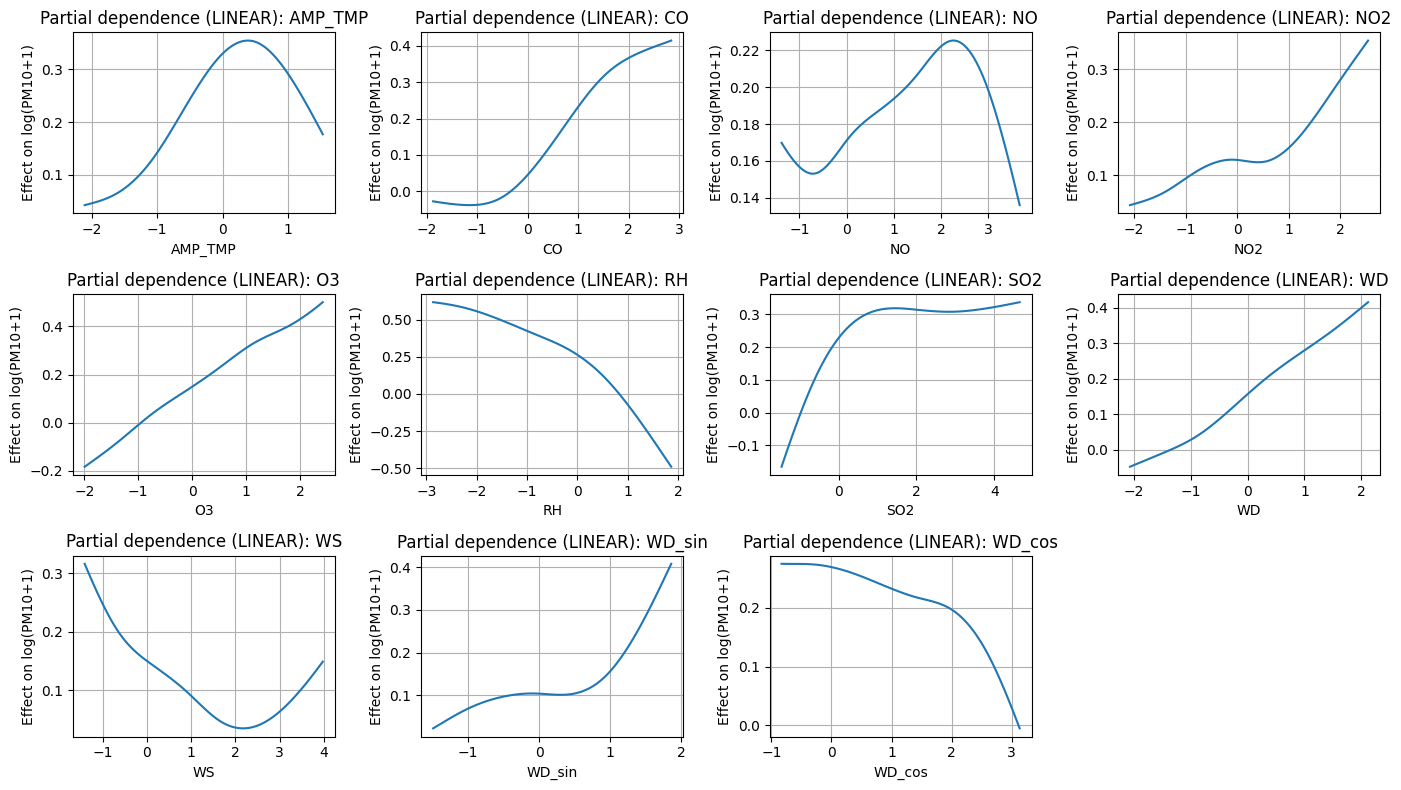

In [179]:
####################################################
# PARTIAL DEPENDENCE PLOTS (LinearGAM)
####################################################
predictor_names = df.drop(columns=['PM10']).columns
fig, axs = plt.subplots(3,4 , figsize=(14, 8))
axs = axs.flatten()

for i, ax in enumerate(axs[:len(predictor_names)]):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.set_title(f"Partial dependence (LINEAR): {predictor_names[i]}")
    ax.set_ylabel('Effect on ' + ('log(PM10+1)' if USE_LOG_TARGET else 'PM10'))
    ax.set_xlabel(predictor_names[i])
    ax.grid(True)

for j in range(len(predictor_names), len(axs)):
  fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
print("")

In [180]:
# Saving plot

fig.savefig("Partial_dependence_linear_plots.pdf", bbox_inches='tight')
# files.download("Partial_dependence_linear_plots.pdf")

In [181]:
####################################################
# GAMMA GAM
####################################################
terms_g = TermList(*[s(i) for i in range(X_train.shape[1])])
gamma_gam = GAM(terms_g, distribution=GammaDist(), link=LogLink())
# quick lam per-term gridsearch could be added; use fixed for simplicity
gamma_gam.fit(X_train, y_train)   # note: on natural scale

print("\n########## GAMMA GAM SUMMARY ##########\n")
print(gamma_gam.summary())

y_test_pred_g = gamma_gam.predict(X_test)
r2_test_g = r2_score(y_test, y_test_pred_g)
mae_test_g = mean_absolute_error(y_test, y_test_pred_g)
rmse_test_g = mean_squared_error(y_test, y_test_pred_g) ** 0.5
vaf_test_g = vaf(y_test, y_test_pred_g)

print("")
print("Test MAE:", mae_test_g)
print("Test RMSE:", rmse_test_g)
print("Test R²:", r2_test_g)
print("Test VAF:", vaf_test_g)
print("")


########## GAMMA GAM SUMMARY ##########

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                         GammaDist Effective DoF:                                    121.0024
Link Function:                          LogLink Log Likelihood:                                 -3310.6812
Number of Samples:                          876 AIC:                                             6865.3672
                                                AICc:                                            6905.2255
                                                GCV:                                                0.1458
                                                Scale:                                              0.1232
                                                Pseudo R-Squared:                                   0.

/tmp/ipython-input-1440554693.py:10: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gamma_gam.summary())


In [182]:
####################################################
# LINEAR REGRESSION (baseline)
####################################################
from sklearn.linear_model import LinearRegression
print("\n########## LINEAR REGRESSION SUMMARY ##########\n")

linear_reg = LinearRegression().fit(X_train, y_train)
print("Coefficients: ", linear_reg.coef_)
print("Intercept: ", linear_reg.intercept_)

y_test_pred_lr = linear_reg.predict(X_test)
r2_test_lr  = r2_score(y_test, y_test_pred_lr)
mae_test_lr = mean_absolute_error(y_test, y_test_pred_lr)
rmse_test_lr= mean_squared_error(y_test, y_test_pred_lr) ** 0.5
vaf_test_lr = vaf(y_test, y_test_pred_lr)

print("")
print("Test MAE:", mae_test_lr)
print("Test RMSE:", rmse_test_lr)
print("Test R²:", r2_test_lr)
print("Test VAF:", vaf_test_lr)
print(linear_reg.score(X_test, y_test)) # same as R^2
print("")


########## LINEAR REGRESSION SUMMARY ##########

Coefficients:  [  2.5307445    6.82648968  -0.83930492   3.02306316   5.53871187
  -7.97586979   3.08401288 -13.93453131  -1.59947832 -14.18343745
   1.97317854]
Intercept:  38.30619470605029

Test MAE: 9.059919807915913
Test RMSE: 11.604241724148677
Test R²: 0.5400054889624688
Test VAF: 54.06220116480497
0.5400054889624688



In [183]:
####################################################
# RANDOM FOREST (steadier tuned defaults)  >>> CHANGED
####################################################
from sklearn.ensemble import RandomForestRegressor
print("\n########## RANDOM FOREST SUMMARY ##########\n")

rf = RandomForestRegressor(                                   # >>> CHANGED
    n_estimators=600,                                         # >>> NEW
    max_depth=None,                                           # >>> NEW
    min_samples_split=4,                                      # >>> NEW
    min_samples_leaf=2,                                       # >>> NEW
    max_features='sqrt',                                      # >>> NEW
    bootstrap=True,                                           # >>> NEW
    random_state=18,
    n_jobs=-1
).fit(X_train, y_train)

y_test_pred_rf = rf.predict(X_test)
r2_test_rf  = r2_score(y_test, y_test_pred_rf)
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)
rmse_test_rf= mean_squared_error(y_test, y_test_pred_rf) ** 0.5
vaf_test_rf = vaf(y_test, y_test_pred_rf)

print("")
print("Test MAE:", mae_test_rf)
print("Test RMSE:", rmse_test_rf)
print("Test R²:", r2_test_rf)
print("Test VAF:", vaf_test_rf)
print(rf.score(X_test, y_test))
print("")

# Cross-validated RF R²
scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("Average 5-Fold CV R² for Random Forest:", scores.mean())
print("")


########## RANDOM FOREST SUMMARY ##########


Test MAE: 8.835012612675905
Test RMSE: 12.055169523449846
Test R²: 0.5035611515415729
Test VAF: 51.171875674502175
0.5035611515415729

Average 5-Fold CV R² for Random Forest: 0.44806807345494504



In [184]:
####################################################
# MODEL COMPARISON SUMMARY TABLE  >>> CHANGED
####################################################
results = pd.DataFrame({
    'Model': ['LinearGAM', 'GammaGAM', 'LinearRegression', 'RandomForest'],
    'Test R²':  [r2_l, r2_test_g, r2_test_lr, r2_test_rf],       # >>> CHANGED
    'Test RMSE':[rmse_l, rmse_test_g, rmse_test_lr, rmse_test_rf],
    'Test MAE': [mae_l, mae_test_g, mae_test_lr, mae_test_rf],
    'Test VAF %':[vaf_l, vaf_test_g, vaf_test_lr, vaf_test_rf]
})
print("\n########## MODEL COMPARISON ##########\n")
display(results)
print("")



########## MODEL COMPARISON ##########



,Model,Test R²,Test RMSE,Test MAE,Test VAF %
0,LinearGAM,0.615179,10.613770,8.022404,61.925355
1,GammaGAM,0.546337,11.524108,8.706569,54.876251
2,LinearRegression,0.540005,11.604242,9.059920,54.062201
3,RandomForest,0.503561,12.055170,8.835013,51.171876


In [185]:
# Prints code for latex for Model Comparison table
latex_code_model_comparison = results.to_latex(index=True, float_format="{:.2f}".format)
print(latex_code_model_comparison)

\begin{tabular}{llrrrr}
\toprule
 & Model & Test R² & Test RMSE & Test MAE & Test VAF % \\
\midrule
0 & LinearGAM & 0.62 & 10.61 & 8.02 & 61.93 \\
1 & GammaGAM & 0.55 & 11.52 & 8.71 & 54.88 \\
2 & LinearRegression & 0.54 & 11.60 & 9.06 & 54.06 \\
3 & RandomForest & 0.50 & 12.06 & 8.84 & 51.17 \\
\bottomrule
\end{tabular}



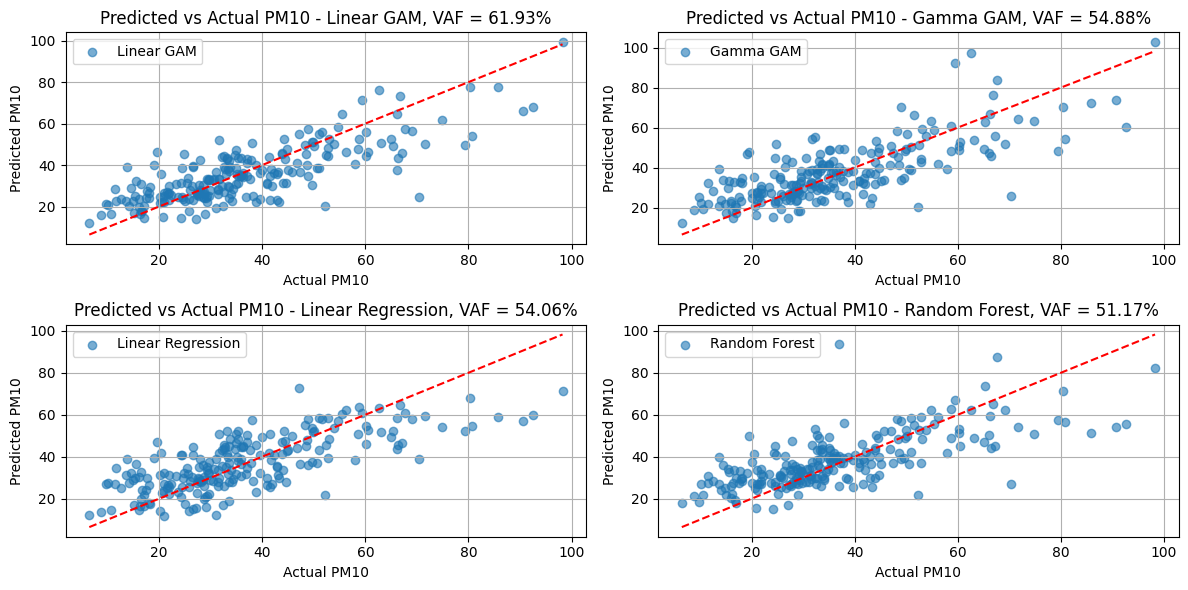

In [186]:
###################################################
# PREDICTED VS ACTUAL VALUES (plots)
####################################################
models = ['Linear GAM', 'Gamma GAM', 'Linear Regression', 'Random Forest']
predictions = [y_pred_report, y_test_pred_g, y_test_pred_lr, y_test_pred_rf]  # >>> CHANGED (use y_pred_report for GAM)
vafs = [vaf_l, vaf_test_g, vaf_test_lr, vaf_test_rf]

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
for i, ax in enumerate(axs.flatten()):
    ax.scatter(y_test, predictions[i], alpha=0.6, label=models[i])
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    ax.set_xlabel("Actual PM10")
    ax.set_ylabel("Predicted PM10")
    ax.set_title(f"Predicted vs Actual PM10 - {models[i]}, VAF = {vafs[i]:.2f}%")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
print("")


In [187]:
# Saving plot

fig.savefig("Predicted_vs_actual_PM10_TEST.pdf", bbox_inches='tight')
#files.download("Predicted_vs_actual_PM10_TEST.pdf")

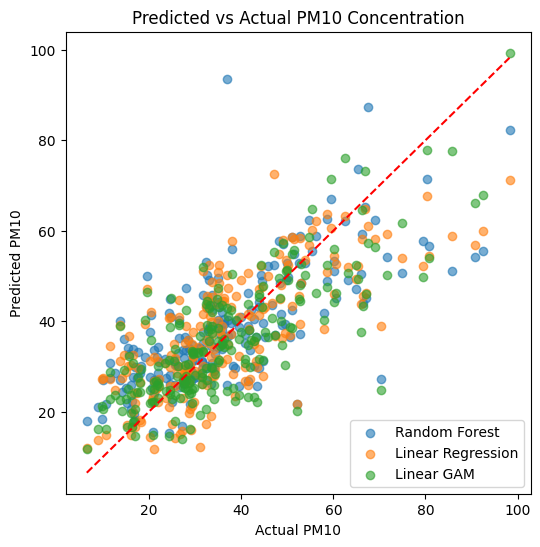

In [188]:
# Combined plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred_rf, alpha=0.6, label='Random Forest')
plt.scatter(y_test, y_test_pred_lr, alpha=0.6, label='Linear Regression')
plt.scatter(y_test, y_pred_report, alpha=0.6, label='Linear GAM')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual PM10"); plt.ylabel("Predicted PM10")
plt.title("Predicted vs Actual PM10 Concentration")
plt.legend(); plt.show(); print("")


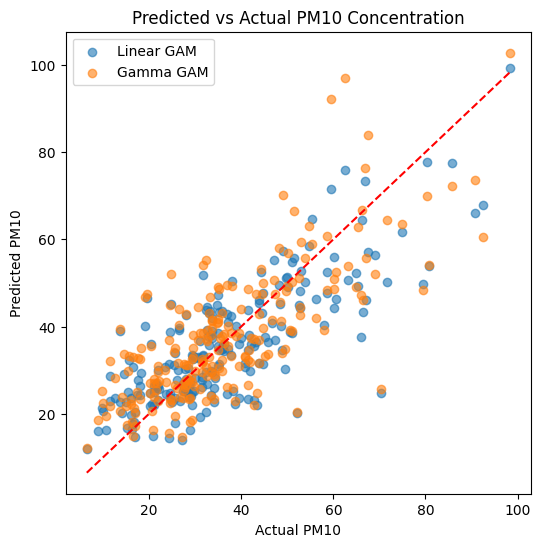

In [189]:
# GAM vs GAMMA only
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_report, alpha=0.6, label='Linear GAM')  # >>> CHANGED
plt.scatter(y_test, y_test_pred_g, alpha=0.6, label='Gamma GAM')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual PM10"); plt.ylabel("Predicted PM10")
plt.title("Predicted vs Actual PM10 Concentration")
plt.legend(); plt.show(); print("")

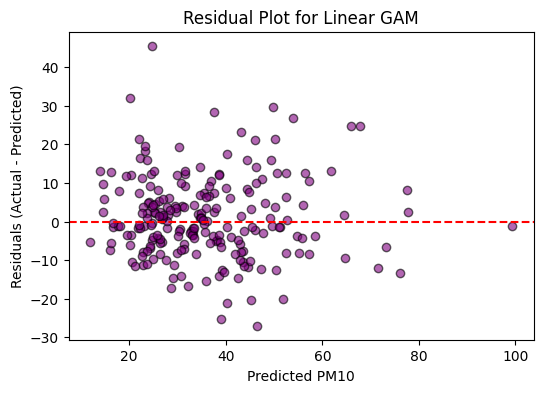

Mean of residuals: 1.0921104385380076
Standard deviation of residuals: 10.557433909632842



In [190]:
####################################################
# RESIDUAL PLOT (ERROR ANALYSIS) – use best model you prefer
####################################################
residuals = y_test - y_pred_report     # >>> CHANGED (residuals for GAM on natural scale)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_report, residuals, alpha=0.6, color='purple', edgecolor='black')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot for Linear GAM")
plt.xlabel("Predicted PM10")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()

print("Mean of residuals:", np.mean(residuals))
print("Standard deviation of residuals:", np.std(residuals))
print("")

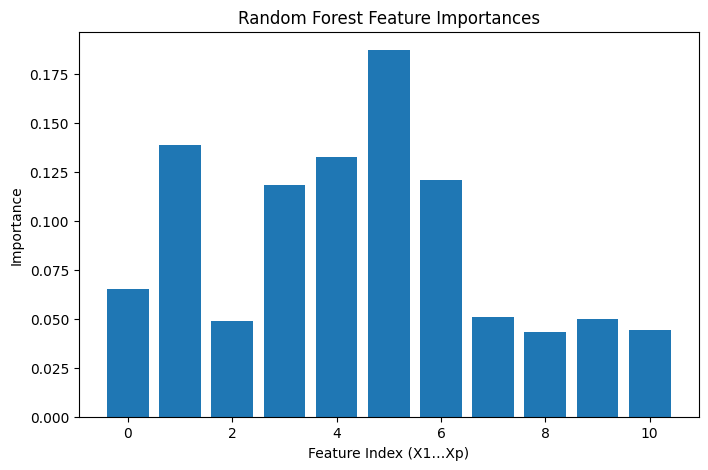

In [191]:
####################################################
# FEATURE IMPORTANCE (RANDOM FOREST)
####################################################
importances = rf.feature_importances_
plt.figure(figsize=(8,5))
plt.bar(range(len(importances)), importances)
plt.title("Random Forest Feature Importances")
plt.xlabel("Feature Index (X1…Xp)")
plt.ylabel("Importance")
plt.show()
print("")

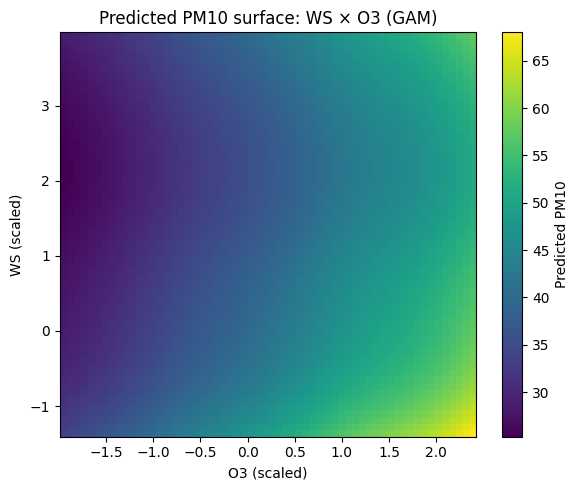

In [192]:
####################################################
# >>> NEW: WS × O3 PREDICTION SURFACE (GAM) – version-proof
####################################################
feat_names = df.drop(columns=['PM10']).columns.tolist()      # >>> NEW
if 'WS' in feat_names and 'O3' in feat_names:                 # >>> NEW
    i_ws = feat_names.index('WS'); i_o3 = feat_names.index('O3')
    grid_n = 60
    ws_vals = np.linspace(X_test[:, i_ws].min(), X_test[:, i_ws].max(), grid_n)
    o3_vals = np.linspace(X_test[:, i_o3].min(), X_test[:, i_o3].max(), grid_n)
    center = X_train.mean(axis=0, keepdims=True)

    Z = np.empty((grid_n, grid_n))
    for a, ws in enumerate(ws_vals):
        for b, o3 in enumerate(o3_vals):
            x = center.copy()
            x[0, i_ws] = ws; x[0, i_o3] = o3
            Z[a, b] = gam.predict(x)[0]

    Z_plot = np.expm1(Z) if USE_LOG_TARGET else Z
    extent = [o3_vals.min(), o3_vals.max(), ws_vals.min(), ws_vals.max()]
    plt.figure(figsize=(6,5))
    plt.imshow(Z_plot, origin='lower', aspect='auto', extent=extent)
    plt.xlabel("O3 (scaled)"); plt.ylabel("WS (scaled)")
    plt.title("Predicted PM10 surface: WS × O3 (GAM)")
    plt.colorbar(label="Predicted PM10")
    plt.tight_layout(); plt.show()